### Train schedules data from Digitraffic

Data from Digitraffic's [https://rata.digitraffic.fi](https://rata.digitraffic.fi)-interface. License [CC 4.0 BY](http://creativecommons.org/licenses/by/4.0/)


### Weather data from the Finnish Meteorological Insititute
https://en.ilmatieteenlaitos.fi/open-data (MIT license)

---



## Predicting, multi-layer perceptron

In this version, the "Delay" -column is converted to "Delay - Delay at Dep." -difference. 

Features are only weather conditions, target is the delay difference. So as the result we are predicting the difference.

To compare predictions to actual times, the "Delay at Dep." must finally be added to results.

### Select training data, from winter 2016-2017

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

# --------------- TRAINING DATA ----------------- 
training = pd.DataFrame(pd.read_csv('data/JY-HKI-dec16-mar17.csv'))
tg2 = pd.DataFrame(pd.read_csv('data/SK-OL-dec16-mar17.csv'))
tg3 = pd.DataFrame(pd.read_csv('data/KUO-KV-dec16-mar17.csv'))
tg3 = tg3.fillna(0)
training = training.append(tg2)
training = training.append(tg3)

In [68]:
# Get only long-distance trains
training = training.loc[(training['Category'] == 'Long-distance')  & (training['Train ID'] < 10000) ]

# Drop the columns we don't need, and leave the most correlating
training.drop(training.columns[[0,1,2,3,4,6,7,8]], axis=1, inplace=True)
training = training.reset_index(drop=True)

training['Delay'] = training['Delay'] - training['Delay at Dep.']
training.drop(['Delay at Dep.'], axis=1, inplace=True)

# Save the column names, we need them after scaling
colnames = training.columns

# train the normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(training)

# Scale dataframe and place column names
training2 = pd.DataFrame(scaler.transform(training), columns=colnames)
training2.head()

,Delay,12h Coldest Arrival,12h Rain max Arrival,12h Rain total Arrival,12h Snow depth Arrival,12h Coldest Dep,12h Rain max Dep,12h Rain total Dep,12h Snow depth Dep
0,-0.480953,0.521311,-1.0,-1.0,-1.0,0.618421,-1.0,-1.0,-0.925926
1,-0.478290,0.521311,-1.0,-1.0,-1.0,0.618421,-1.0,-1.0,-0.925926
2,-0.470015,0.521311,-1.0,-1.0,-1.0,0.500000,-1.0,-1.0,-0.925926
3,-0.448043,0.521311,-1.0,-1.0,-1.0,0.296053,-1.0,-1.0,-0.962963
4,-0.449184,0.521311,-1.0,-1.0,-1.0,0.078947,-1.0,-1.0,-0.962963


### Select target and training columns for MLP

In [69]:
# ----------------- TARGET ----------------
y = training2.iloc[:,0]                            #y = (y - y.mean())/y.std()  # z-score normalization

# Set training columns = all but 'Delay'
X = training2.loc[:, training2.columns != 'Delay'] #or:   X = training2.iloc[:, training2.columns != 0]
X.head()

,12h Coldest Arrival,12h Rain max Arrival,12h Rain total Arrival,12h Snow depth Arrival,12h Coldest Dep,12h Rain max Dep,12h Rain total Dep,12h Snow depth Dep
0,0.521311,-1.0,-1.0,-1.0,0.618421,-1.0,-1.0,-0.925926
1,0.521311,-1.0,-1.0,-1.0,0.618421,-1.0,-1.0,-0.925926
2,0.521311,-1.0,-1.0,-1.0,0.500000,-1.0,-1.0,-0.925926
3,0.521311,-1.0,-1.0,-1.0,0.296053,-1.0,-1.0,-0.962963
4,0.521311,-1.0,-1.0,-1.0,0.078947,-1.0,-1.0,-0.962963


### Test data. Predictions for data from winter 2017-2018

In [70]:
# -------------- TESTING DATA ---------------
testing = pd.DataFrame(pd.read_csv('data/JY-HKI-dec17-mar18.csv'))
testing.drop(testing.columns[[0]], axis=1, inplace=True)

# Get only long-distance trains (and train numbers over 10000, which are unordinary)
testing = testing.loc[(testing['Category'] == 'Long-distance')  & (testing['Train ID'] < 10000) ]
testing = testing.reset_index(drop=True)

# Drop columns (useless for this algorithm)
testing.drop(testing.columns[[0,1,2,3,5,6,7]], axis=1, inplace=True)

testdata = testing.loc[:, testing.columns != 'Delay']
# Scale testdata, use same column names as before
testdata = pd.DataFrame(scaler.transform(testdata), columns=colnames)

# Select all but 'Delay' column. We can later compare this real delay information to our predictions.
testdata = testdata.loc[:, testdata.columns != 'Delay']  # or:  testdata = testdata.iloc[:, testdata.columns != 0]
testdata.head()

,12h Coldest Arrival,12h Rain max Arrival,12h Rain total Arrival,12h Snow depth Arrival,12h Coldest Dep,12h Rain max Dep,12h Rain total Dep,12h Snow depth Dep
0,0.593443,-0.5,-0.486486,-1.000000,0.723684,-0.60,-0.603604,-1.148148
1,0.593443,-0.4,-0.189189,-1.000000,0.723684,-0.52,-0.405405,-1.148148
2,0.580328,0.0,0.270270,-0.837838,0.703947,-0.20,-0.135135,-1.111111
3,0.580328,0.0,0.459459,-0.837838,0.690789,-0.20,0.045045,-1.111111
4,0.580328,0.0,0.432432,-0.783784,0.690789,-0.20,0.063063,-1.074074


### Prediction
Fit Multi Layer Perceptron to training data, and predict on 'testdata'

In [71]:
max_iter = 200
layers = (5)
alphas = 0.1
init = 0.1

# alusta mlp 
mlp = MLPRegressor(verbose=0, random_state=0, max_iter=max_iter, batch_size='auto', activation='identity',
                  learning_rate_init=init, solver='lbfgs', alpha=alphas, hidden_layer_sizes=layers )
mlp.fit(X, y)

# Print score
print("Algorithm score: %f" % mlp.score(X, y))

# Predict the delays
result = mlp.predict(testdata)

Algorithm score: 0.007101


In [72]:
# The predictions column has to be inserted to first position of the dataframe before scaling back, 
# because that's where the original 'Delay' column was before the scaling

results = testdata.copy()
results.insert(0, 'preds', result)#
results = pd.DataFrame(scaler.inverse_transform(results), columns=colnames)

results['Delay'] = results['Delay']+testing['Delay at Dep.']

# insert actual values for comparison
results.insert(0, 'ACTUAL', testing['Delay'])#
results.sample(3)

,ACTUAL,Delay,12h Coldest Arrival,12h Rain max Arrival,12h Rain total Arrival,12h Snow depth Arrival,12h Coldest Dep,12h Rain max Dep,12h Rain total Dep,12h Snow depth Dep
373,1,234.719253,-11.3,0.0,0.0,8.0,-25.7,0.1,0.1,46.0
90,391,40.580964,0.3,0.7,1.2,2.0,-2.8,0.7,1.2,27.0
310,89,-39.281336,-5.9,0.0,0.0,0.0,-5.9,0.0,0.0,41.0



### Visualisation of predicted delays vs. actual delays

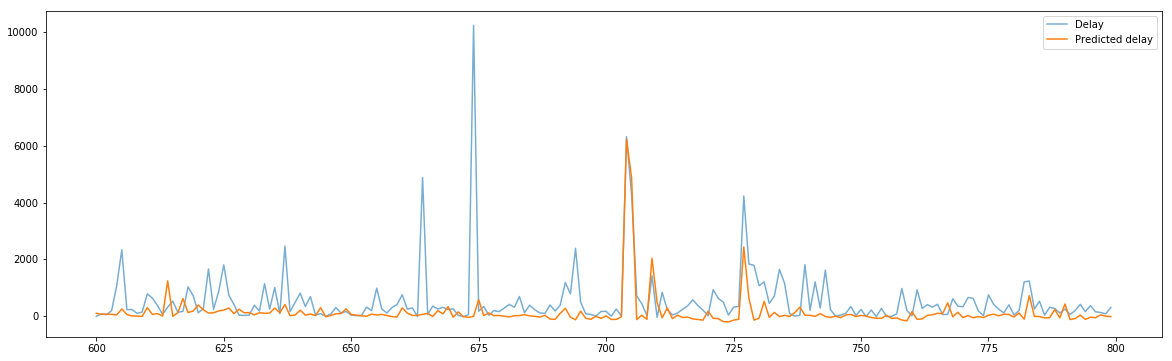

In [73]:
# A piece of data...
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
plt.plot(results.index.values[600:800], results['ACTUAL'][600:800], label="Delay", alpha=0.6)
plt.plot(results.index.values[600:800], results['Delay'][600:800], label="Predicted delay", alpha=1)
plt.legend()
plt.show()

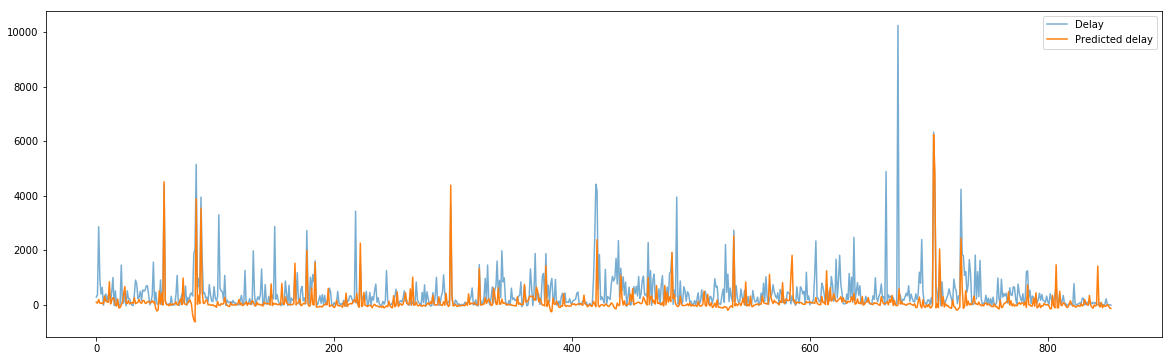

In [74]:
# All the data...
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
plt.plot(results.index.values, results['ACTUAL'], label="Delay", alpha=0.6)
plt.plot(results.index.values, results['Delay'], label="Predicted delay", alpha=1)
plt.legend()
plt.show()